In [1]:
# The University of Chicago
# Spring 2022
# ECMA 33620 Intro to Heterogeneous Agent Macroeconomics
# Instructor: Prof. Greg Kaplan

# Problem Set 1, Part 3
# (MATLAB translated to Python)
# Chongyu Fang

#%% PACKAGES
import numpy as np
import matplotlib.pyplot as plt

#%% PARAMETERS

# Horizon
T = 50

# Preferences
risk_aver = 1.5
beta = 0.98
Phi = 0.5

# Returns
r = 0.02
#r = 0.01
R = 1 + r

# Wage
wage = np.zeros(T)
wage[0:25] = np.arange(1, 26)
wage[25:50] = np.arange(25, 0, -1)
wage = wage / 10
#wage = wage * (1-0.4) / 10

# Unemployment benefits
benefit = 0.5
#benefit = 0.1

# Asset grids
na = 1000
amax = 20  # Upper limit of asset on asset grid
borrow_lim = 0
agrid_par = 1  # 1 for linear, 0 for L-shaped

In [2]:
#%% OPTIONS
Display = 1
DoSimulate = 1
MakePlots = 1

In [3]:
#%% SET UP GRIDS

# Assets
agrid = np.linspace(0, 1, na)
agrid = agrid ** (1 / agrid_par)
agrid = borrow_lim + (amax - borrow_lim) * agrid

# ensures that the asset grid includes the value 0 explicitly
# even if it wasn’t part of the grid initially due to the grid's resolution or construction method
aclose_idx = np.argmin(np.abs(agrid - 0))
agrid[aclose_idx] = 0

#%% UTILITY FUNCTION

if risk_aver == 1:
    def u(c):
        return np.log(c)
else:
    def u(c):
        return (c ** (1 - risk_aver) - 1) / (1 - risk_aver)

def u1(c):
    return c ** (-risk_aver)

In [4]:
#%% INITIALIZE ARRAYS
V = np.zeros((na, T))          # Value function
con = np.zeros((na, T))        # Consumption policy function c(a)
sav = np.zeros((na, T))        # Saving policy function a'(a)
savind = np.zeros((na, T), dtype=int)  # Index of a' on grid
h = np.zeros((na, T))          # Optimal working decision h

#%% DECISIONS AT t=T, note Python is 0-based index while MATLAB is 1-based
savind[:, T - 1] = aclose_idx  # At t=T, trivially do not save
sav[:, T - 1] = 0
h[:, T - 1] = 0                # At t=T, trivially do not work
con[:, T - 1] = R * agrid + wage[T - 1] * h[:, T - 1] + benefit * (1 - h[:, T - 1]) - sav[:, T - 1]
V[:, T - 1] = u(np.maximum(con[:, T - 1], 1.0e-10))

In [5]:
#%% SOLVE VALUE FUNCTION BACKWARD

for it in range(T - 2, -1, -1):
    if Display >= 1:
        print(f"Solving at age: {it + 1}")
        
    # Loop over assets
    for ia in range(na):
        # Optimal working decision
        cash_work = R * agrid[ia] + wage[it]
        cash_notwork = R * agrid[ia] + benefit

        # Possible consumption for all future asset choices
        consumption_work = np.maximum(cash_work - agrid, 1.0e-10)
        consumption_notwork = np.maximum(cash_notwork - agrid, 1.0e-10)

        # Value choices for working and not working
        Vchoice_work = u(consumption_work) - Phi + beta * V[:, it + 1]
        Vchoice_notwork = u(consumption_notwork) + beta * V[:, it + 1]

        # Compare values between work/not work
        if np.max(Vchoice_work) >= np.max(Vchoice_notwork):
            V[ia, it] = np.max(Vchoice_work)
            savind[ia, it] = np.argmax(Vchoice_work)
            h[ia, it] = 1
            cash = cash_work
        else:
            V[ia, it] = np.max(Vchoice_notwork)
            savind[ia, it] = np.argmax(Vchoice_notwork)
            h[ia, it] = 0
            cash = cash_notwork

        # Update savings and consumption
        sav[ia, it] = agrid[savind[ia, it]]
        con[ia, it] = cash - sav[ia, it]

Solving at age: 49
Solving at age: 48
Solving at age: 47
Solving at age: 46
Solving at age: 45
Solving at age: 44
Solving at age: 43
Solving at age: 42
Solving at age: 41
Solving at age: 40
Solving at age: 39
Solving at age: 38
Solving at age: 37
Solving at age: 36
Solving at age: 35
Solving at age: 34
Solving at age: 33
Solving at age: 32
Solving at age: 31
Solving at age: 30
Solving at age: 29
Solving at age: 28
Solving at age: 27
Solving at age: 26
Solving at age: 25
Solving at age: 24
Solving at age: 23
Solving at age: 22
Solving at age: 21
Solving at age: 20
Solving at age: 19
Solving at age: 18
Solving at age: 17
Solving at age: 16
Solving at age: 15
Solving at age: 14
Solving at age: 13
Solving at age: 12
Solving at age: 11
Solving at age: 10
Solving at age: 9
Solving at age: 8
Solving at age: 7
Solving at age: 6
Solving at age: 5
Solving at age: 4
Solving at age: 3
Solving at age: 2
Solving at age: 1


In [6]:
#%% SIMULATE
# Since we derived c(a), a'(a), h(a), we can simulate consumption, wealth, work decision path now
if DoSimulate == 1:
    aindsim = np.zeros(T + 1, dtype=int)  # Asset index simulation

    # Initial assets: starting with a0 = 0
    ainitial = 0
    aindsim[0] = np.argmin(np.abs(agrid - ainitial))  # Find the closest index on the grid
    
    # Simulate forward
    for it in range(T):
        if Display >= 1:
            print(f"Simulating, time period {it + 1}")
        # Asset choice
        aindsim[it + 1] = savind[aindsim[it], it]

    # Assign actual asset, income, and work values
    asim = agrid[aindsim]
    hsim = np.zeros(T)
    y = np.zeros(T)
    for ih in range(T):
        hsim[ih] = h[aindsim[ih], ih]
        y[ih] = wage[ih] * hsim[ih] + benefit * (1 - hsim[ih])
    csim = R * asim[:T] + y - asim[1:T + 1]

Simulating, time period 1
Simulating, time period 2
Simulating, time period 3
Simulating, time period 4
Simulating, time period 5
Simulating, time period 6
Simulating, time period 7
Simulating, time period 8
Simulating, time period 9
Simulating, time period 10
Simulating, time period 11
Simulating, time period 12
Simulating, time period 13
Simulating, time period 14
Simulating, time period 15
Simulating, time period 16
Simulating, time period 17
Simulating, time period 18
Simulating, time period 19
Simulating, time period 20
Simulating, time period 21
Simulating, time period 22
Simulating, time period 23
Simulating, time period 24
Simulating, time period 25
Simulating, time period 26
Simulating, time period 27
Simulating, time period 28
Simulating, time period 29
Simulating, time period 30
Simulating, time period 31
Simulating, time period 32
Simulating, time period 33
Simulating, time period 34
Simulating, time period 35
Simulating, time period 36
Simulating, time period 37
Simulating

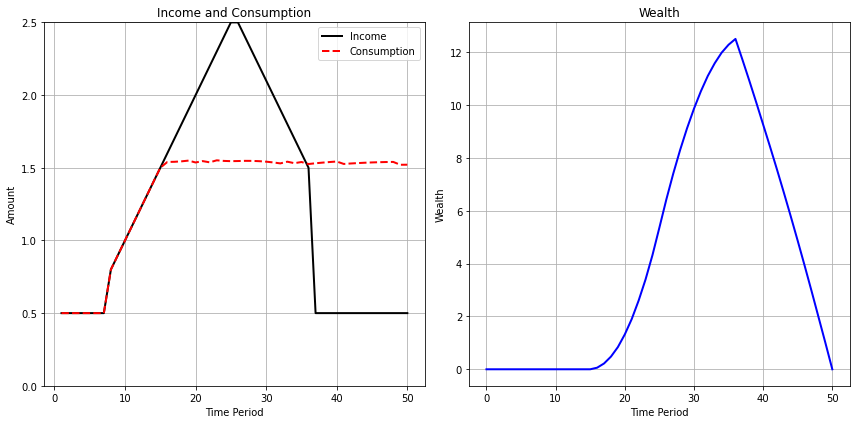

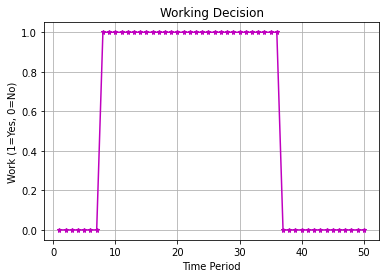

In [7]:
#%% MAKE PLOTS
if MakePlots == 1:
    plt.figure(1, figsize=(12, 6))

    # Consumption and income path
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, T + 1), y, 'k-', linewidth=2, label='Income')
    plt.plot(np.arange(1, T + 1), csim, 'r--', linewidth=2, label='Consumption')
    plt.grid(True)
    plt.title('Income and Consumption')
    plt.legend()
    plt.ylim([0, 2.5])
    plt.xlabel('Time Period')
    plt.ylabel('Amount')

    # Wealth path function
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, T + 1), asim, 'b-', linewidth=2)
    plt.grid(True)
    plt.title('Wealth')
    plt.xlabel('Time Period')
    plt.ylabel('Wealth')

    plt.tight_layout()
    plt.show()

    plt.figure(2, figsize=(6, 4))

    # Optimal working decision path
    plt.plot(np.arange(1, T + 1), hsim, '-m*', markersize=5)
    plt.grid(True)
    plt.title('Working Decision')
    plt.xlabel('Time Period')
    plt.ylabel('Work (1=Yes, 0=No)')

    plt.show()